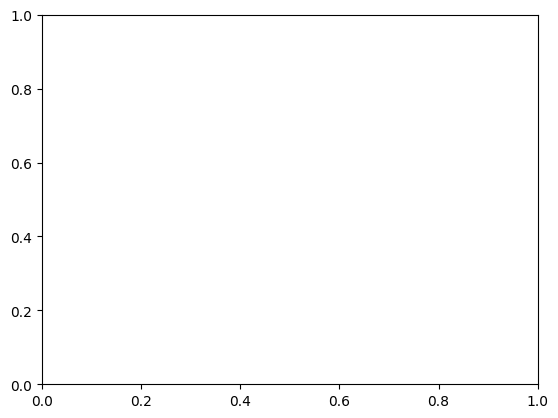

In [1]:
# %matplotlib widget

import pandas as pd
import warnings
from pandas import DataFrame
from scipy.signal import filtfilt, butter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# plt.ion()
import matplotlib.ticker
import matplotlib.dates as mdates
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from parser_utils import folder_selection_utils
from scipy.stats import linregress
import os
import math
import parser_utils.parser_logger
import logging
import json
from parser_utils import folder_selection_utils
from torque_log_analysis import resample_data,drop_rows_from_df,lpf_df
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from motor import Motor

warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore',category=pd.errors.SettingWithCopyWarning)

plt.style.use('bmh')

# steps


In [2]:
path = r'C:\Users\Matthew Samson\Documents\formula\6_19_23 ECAR COMP\parsed-data\enduranceOnly'


In [3]:

for filename in os.listdir(path):
    # print(f"path: {path}")
    if filename.endswith('.csv') or filename.endswith('.CSV'):
        print(f"Filename: {filename}")
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path)
        df = df[['Time','D1_DC_Bus_Voltage','D1_Commanded_Torque','D2_Motor_Speed','D4_DC_Bus_Current']]
        df = resample_data(df, "Time",resample_interval=1000)
        df = lpf_df(df,1)
        df = drop_rows_from_df(df,"D1_Commanded_Torque",1,400)
        df = drop_rows_from_df(df, "D2_Motor_Speed", 10, 7000)

print(df)



Filename: parseddata0028.CSV


2024-03-15 06:15:01,179 [INFO] torque_log_analysis.py:45: D1_Commanded_Torque: dropped 695 rows
2024-03-15 06:15:01,182 [INFO] torque_log_analysis.py:45: D2_Motor_Speed: dropped 3 rows


1Hz
                     D1_DC_Bus_Voltage  D1_Commanded_Torque  D2_Motor_Speed  \
Time                                                                          
2019-01-01 22:19:46         303.550000            23.963158      103.500000   
2019-01-01 22:19:47         303.327778            23.300000      168.181818   
2019-01-01 22:19:48         301.346154            21.800000      243.000000   
2019-01-01 22:19:49         302.689474            20.300000      275.333333   
2019-01-01 22:19:50         303.390000            14.000000      287.000000   
...                                ...                  ...             ...   
2019-01-01 22:50:43         229.184375             9.018182      711.714286   
2019-01-01 22:50:44         228.533333            15.300000      685.500000   
2019-01-01 22:50:45         229.100000            10.037931      701.200000   
2019-01-01 22:50:46         229.585714             2.758824      607.000000   
2019-01-01 22:50:47         107.204762          

In [4]:
from battery import battery,batteryPack
cell= battery(r'lgHE2ahCurve.csv')
ks6eacc = batteryPack(cell,8,72)
print(ks6eacc.capacity)
print(ks6eacc.voltage)

20000
302.40000000000003


In [5]:
# soe tests cuzhis is fucks
from battery import battery
cell= battery(r'lgHE2ahCurve.csv')
print(cell.voltage)
cell.discharge(2,1800)
cell.updateVoltage()
print(cell.capacity)
print(cell.voltage)

4.2
1500.0
3.7268516313405833


In [6]:


previous_row_name = None


# Function to calculate voltage and capacity at each timestamp
def calculate_battery_values(row):
    global previous_row_name

    # Ignore rows with negative current values
    if row['D4_DC_Bus_Current'] < 0:
        return pd.Series([np.nan, np.nan])

    # Initialize the battery if previous_row_name is None
    if previous_row_name is None:
        previous_row_name = row.name
        return pd.Series([ks6eacc.getInstantaneousVoltage(0), ks6eacc.capacity])
    else:
        # Calculate the time difference
        time_diff = row.name - previous_row_name
        # Assuming the battery is discharged at a constant current for each row's duration
        # print(row)
        current = row['D4_DC_Bus_Current']
        # print(time_diff.total_seconds())
        ks6eacc.discharge(current, time_diff.total_seconds())

        # Save the current timestamp for the next iteration
        previous_row_name = row.name

    # Return the calculated voltage and capacity
    return pd.Series([ks6eacc.getInstantaneousVoltage(current), ks6eacc.capacity])


df[['simbattery_voltage', 'simbattery_capacity']] = df.apply(calculate_battery_values, axis=1)

print(df)


                     D1_DC_Bus_Voltage  D1_Commanded_Torque  D2_Motor_Speed  \
Time                                                                          
2019-01-01 22:19:46         303.550000            23.963158      103.500000   
2019-01-01 22:19:47         303.327778            23.300000      168.181818   
2019-01-01 22:19:48         301.346154            21.800000      243.000000   
2019-01-01 22:19:49         302.689474            20.300000      275.333333   
2019-01-01 22:19:50         303.390000            14.000000      287.000000   
...                                ...                  ...             ...   
2019-01-01 22:50:43         229.184375             9.018182      711.714286   
2019-01-01 22:50:44         228.533333            15.300000      685.500000   
2019-01-01 22:50:45         229.100000            10.037931      701.200000   
2019-01-01 22:50:46         229.585714             2.758824      607.000000   
2019-01-01 22:50:47         107.204762             1

In [7]:
print(list(df))
print(df['simbattery_voltage'])

['D1_DC_Bus_Voltage', 'D1_Commanded_Torque', 'D2_Motor_Speed', 'D4_DC_Bus_Current', 'filtD1_DC_Bus_Voltage', 'filtD1_Commanded_Torque', 'filtD2_Motor_Speed', 'filtD4_DC_Bus_Current', 'simbattery_voltage', 'simbattery_capacity']
Time
2019-01-01 22:19:46    302.405666
2019-01-01 22:19:47    302.206545
2019-01-01 22:19:48    302.199463
2019-01-01 22:19:49    301.974285
2019-01-01 22:19:50    301.968462
                          ...    
2019-01-01 22:50:43    237.311824
2019-01-01 22:50:44    236.690455
2019-01-01 22:50:45    236.846329
2019-01-01 22:50:46    238.163162
2019-01-01 22:50:47    238.273894
Name: simbattery_voltage, Length: 1397, dtype: float64


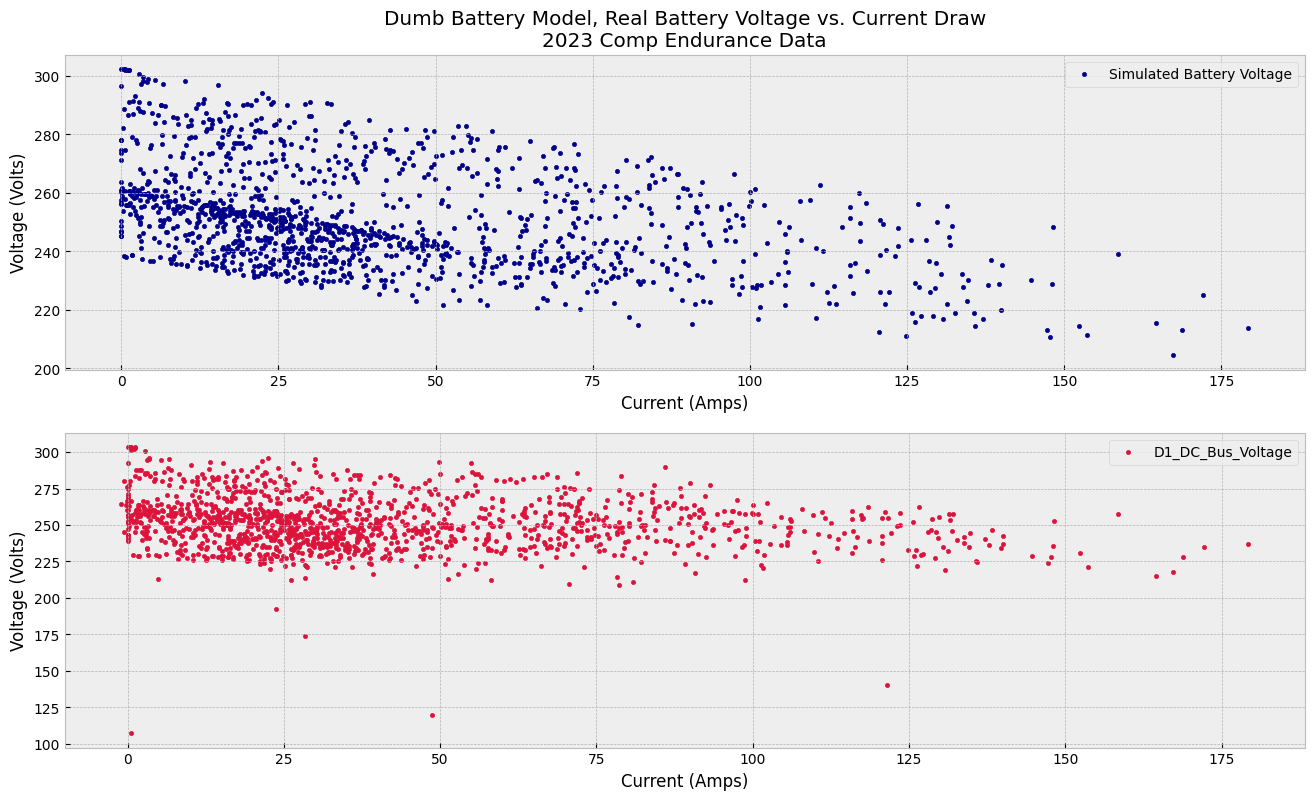

In [8]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9))
ax1.scatter(df['D4_DC_Bus_Current'],df['simbattery_voltage'],label='Simulated Battery Voltage',marker='.',color='darkblue')
ax2.scatter(df['D4_DC_Bus_Current'],df['D1_DC_Bus_Voltage'],label='D1_DC_Bus_Voltage',marker='.',color='crimson')
axes=plt.gcf().get_axes()
axes[0].title.set_text(("Dumb Battery Model, Real Battery Voltage vs. Current Draw\n2023 Comp Endurance Data")
)
for axis in axes:
    axis.legend(loc='upper right')
    axis.set_xlabel('Current (Amps)')
    axis.set_ylabel('Voltage (Volts)')

plt.show()

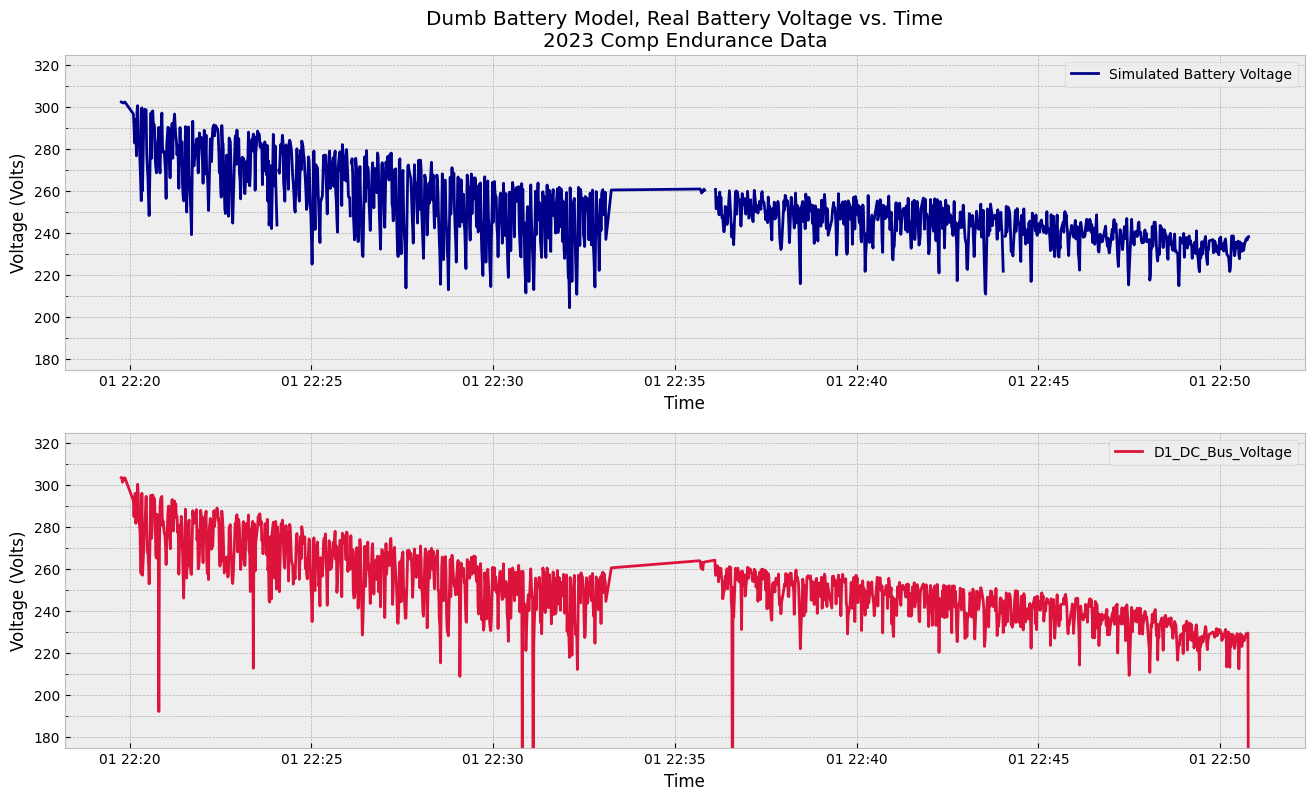

In [9]:
plt.style.use('bmh')
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9))
ax1.plot(df.index,df['simbattery_voltage'],label='Simulated Battery Voltage',color='darkblue')
ax2.plot(df.index,df['D1_DC_Bus_Voltage'],label='D1_DC_Bus_Voltage',color='crimson')
axes=plt.gcf().get_axes()
axes[0].title.set_text(("Dumb Battery Model, Real Battery Voltage vs. Time\n2023 Comp Endurance Data")
)
for axis in axes:
    axis.legend(loc='upper right')
    axis.set_xlabel('Time')
    axis.set_ylabel('Voltage (Volts)')
    axis.set_ylim((175,325))
    axis.yaxis.set_minor_locator(MultipleLocator(10))
    axis.yaxis.grid(True,which='minor')

plt.show()